In [2]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)


from preprocess.graph import graph_topology_5
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from models.graph_water_transformer_cov_no_cnn import graph_water_transformer_cov_gate_predictor_no_cnn

from losses.loss import gate_loss, water_level_threshold
from tensorflow.keras.models import load_model
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from postprocess.threshold import flood_threshold, drought_threshold, flood_threshold_t1, drought_threshold_t1


import random

random.seed(10)
print(random.random())

0.5714025946899135


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [5]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


### Graph topology

In [6]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Model

#### Gate & pump predictor

In [7]:
# ===== model parameters ======
head_size = 96*2
num_heads = 3
ff_dim = 96
num_transformer_blocks = 1
dropout = 0.5
atte_reg = 1e-2
l1_reg = 1e-5
l2_reg = 1e-5
gcn_unit1 = 32
gcn_unit2 = 16
lstm_units = 32
gate_min = 0.0
gate_max = 1.0

learning_rate = 3e-3
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 100
EPOCHS = 700
BATCH = 512

In [8]:
input_shape = train_cov.shape[1:]

In [10]:
gate_predictor, GCNConv = graph_water_transformer_cov_gate_predictor_no_cnn(input_shape=input_shape,
                                                                           gcn1=gcn_unit1,
                                                                           gcn2=gcn_unit2,
                                                                           lstm_unit=lstm_units, 
                                                                           num_transformer_blocks=num_transformer_blocks,
                                                                           head_size=head_size,
                                                                           num_heads=num_heads,
                                                                           ff_dim=ff_dim, 
                                                                           atte_reg=atte_reg, 
                                                                           l1_reg=l1_reg, 
                                                                           l2_reg=l2_reg, 
                                                                           dropout=dropout,
                                                                           masked_value=masked_value,
                                                                           gate_min=gate_min,
                                                                           gate_max=gate_max
                                                                          )
gate_predictor._name = "gate_predictor"
# gate_predictor.summary()

2023-08-12 11:42:07.907499: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1


In [11]:
gate_predictor.compile(optimizer='adam', loss='mse')

#### water stage predictor

In [12]:
ws_predictor = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

for layer in ws_predictor.layers:
    layer.trainable = False

ws_predictor._name = 'ws_predictor'    
# ws_predictor.summary()

#### Combine gate_predictor and trained ws_predictor

In [13]:
inputs_cov = Input(shape=(96, 12), name='input_cov')
inputs_tws = Input(shape=(5, 72), name='input_tws')
inputs_adj = Input(shape=(5, 5), name='input_adj')

# ================ gate_predictor ================
gate_predictor_output = gate_predictor([inputs_cov, inputs_tws, inputs_adj])  # 24*7


# ============  future inputs with replaced gate & pump prediction ============
replaced_future_gate_pump = layers.Concatenate(axis=-1)([inputs_cov[:, n_hours:, :2], 
                                                         gate_predictor_output, 
                                                         inputs_cov[:, n_hours:, 9:]
                                                        ]
                                                       )

# ============ original past inputs + future inputs with replaced gate & pump prediction ============
merged_inputs_cov = layers.Concatenate(axis=1)([inputs_cov[:, :n_hours, :], replaced_future_gate_pump])

ws_predictor_output = ws_predictor([merged_inputs_cov, inputs_tws, inputs_adj])

filda = Model(inputs=[inputs_cov, inputs_tws, inputs_adj], outputs=[gate_predictor_output, ws_predictor_output], name='filda')
# filda.summary()

Epoch 1/700


2023-08-12 11:42:30.841370: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-12 11:42:32.168216: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7342ba3660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-12 11:42:32.168283: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-08-12 11:42:32.178077: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-12 11:42:32.561440: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_ws_predictor_loss improved from inf to 2.73842, saving model to ../saved_models/gtnp_gtnp_13_no_cnn.h5
151/151 - 27s - loss: 0.4903 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2343 - val_loss: 5.4776 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.7384 - 27s/epoch - 178ms/step
Epoch 2/700


/aul/homes/jshi008/miniconda3/envs/tf213/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_ws_predictor_loss improved from 2.73842 to 2.59043, saving model to ../saved_models/gtnp_gtnp_13_no_cnn.h5
151/151 - 13s - loss: 0.4501 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2249 - val_loss: 5.1809 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.5904 - 13s/epoch - 84ms/step
Epoch 3/700

Epoch 3: val_ws_predictor_loss did not improve from 2.59043
151/151 - 12s - loss: 0.4406 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2203 - val_loss: 5.2862 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.6431 - 12s/epoch - 83ms/step
Epoch 4/700

Epoch 4: val_ws_predictor_loss improved from 2.59043 to 2.50914, saving model to ../saved_models/gtnp_gtnp_13_no_cnn.h5
151/151 - 13s - loss: 0.4349 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2174 - val_loss: 5.0183 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.5091 - 13s/epoch - 84ms/step
Epoch 5/700

Epoch 5: val_ws_predictor_loss improved from 2.5

151/151 - 13s - loss: 0.3876 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1938 - val_loss: 3.2826 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.6412 - 13s/epoch - 84ms/step
Epoch 29/700

Epoch 29: val_ws_predictor_loss improved from 1.64119 to 1.64081, saving model to ../saved_models/gtnp_gtnp_13_no_cnn.h5
151/151 - 13s - loss: 0.3873 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1936 - val_loss: 3.2817 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.6408 - 13s/epoch - 84ms/step
Epoch 30/700

Epoch 30: val_ws_predictor_loss improved from 1.64081 to 1.62578, saving model to ../saved_models/gtnp_gtnp_13_no_cnn.h5
151/151 - 13s - loss: 0.3872 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1936 - val_loss: 3.2517 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.6258 - 13s/epoch - 84ms/step
Epoch 31/700

Epoch 31: val_ws_predictor_loss improved from 1.62578 to 1.59722, saving model to ../saved_models/gtnp_g

Epoch 56/700

Epoch 56: val_ws_predictor_loss did not improve from 1.56846
151/151 - 12s - loss: 0.3844 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1922 - val_loss: 3.1432 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.5716 - 12s/epoch - 82ms/step
Epoch 57/700

Epoch 57: val_ws_predictor_loss improved from 1.56846 to 1.56696, saving model to ../saved_models/gtnp_gtnp_13_no_cnn.h5
151/151 - 13s - loss: 0.3840 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1920 - val_loss: 3.1340 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.5670 - 13s/epoch - 83ms/step
Epoch 58/700

Epoch 58: val_ws_predictor_loss improved from 1.56696 to 1.56250, saving model to ../saved_models/gtnp_gtnp_13_no_cnn.h5
151/151 - 13s - loss: 0.3838 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1919 - val_loss: 3.1250 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.5625 - 13s/epoch - 83ms/step
Epoch 59/700

Epoch 59: val_ws_predictor_lo

Epoch 85/700

Epoch 85: val_ws_predictor_loss did not improve from 1.55010
151/151 - 12s - loss: 0.3877 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1934 - val_loss: 3.1221 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.5610 - 12s/epoch - 82ms/step
Epoch 86/700

Epoch 86: val_ws_predictor_loss did not improve from 1.55010
151/151 - 12s - loss: 0.3833 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1916 - val_loss: 3.1262 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.5631 - 12s/epoch - 82ms/step
Epoch 87/700

Epoch 87: val_ws_predictor_loss did not improve from 1.55010
151/151 - 12s - loss: 0.3831 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1915 - val_loss: 3.1370 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.5685 - 12s/epoch - 82ms/step
Epoch 88/700

Epoch 88: val_ws_predictor_loss did not improve from 1.55010
151/151 - 12s - loss: 0.3829 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.19

151/151 - 12s - loss: 0.3825 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1912 - val_loss: 3.1654 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.5827 - 12s/epoch - 82ms/step
Epoch 115/700

Epoch 115: val_ws_predictor_loss did not improve from 1.55010
151/151 - 12s - loss: 0.3825 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1912 - val_loss: 3.1644 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.5822 - 12s/epoch - 82ms/step
Epoch 116/700

Epoch 116: val_ws_predictor_loss did not improve from 1.55010
151/151 - 12s - loss: 0.3824 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1912 - val_loss: 3.1605 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.5803 - 12s/epoch - 82ms/step
Epoch 117/700

Epoch 117: val_ws_predictor_loss did not improve from 1.55010
151/151 - 13s - loss: 0.3824 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1912 - val_loss: 3.1725 - val_gate_predictor_loss: 0.0000e+00 - val_ws_

Epoch 144/700

Epoch 144: val_ws_predictor_loss did not improve from 1.55010
151/151 - 12s - loss: 0.3821 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1910 - val_loss: 3.1976 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.5988 - 12s/epoch - 82ms/step
Epoch 145/700

Epoch 145: val_ws_predictor_loss did not improve from 1.55010
151/151 - 12s - loss: 0.3821 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1911 - val_loss: 3.2130 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.6065 - 12s/epoch - 82ms/step
Epoch 146/700

Epoch 146: val_ws_predictor_loss did not improve from 1.55010
151/151 - 12s - loss: 0.3821 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1911 - val_loss: 3.1972 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.5986 - 12s/epoch - 82ms/step
Epoch 147/700

Epoch 147: val_ws_predictor_loss did not improve from 1.55010
151/151 - 12s - loss: 0.3930 - gate_predictor_loss: 0.0000e+00 - ws_predictor_lo

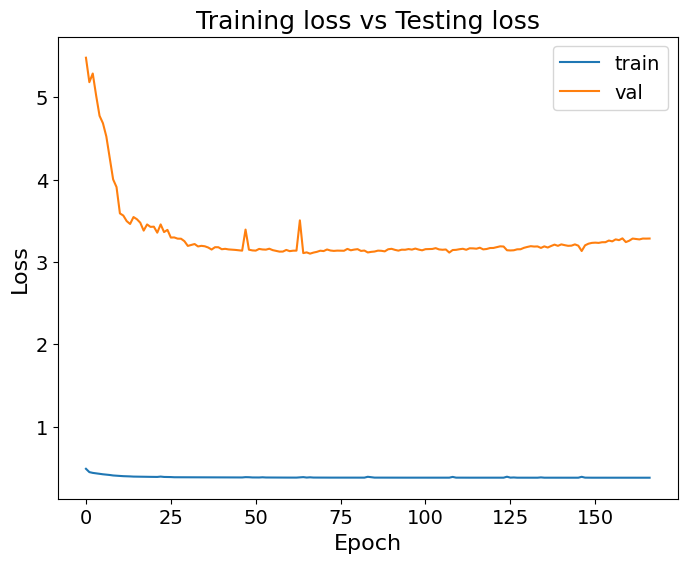

In [14]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
                                                          decay_steps=decay_steps,
                                                          decay_rate=decay_rate)

filda.compile(optimizer=Adam(learning_rate=lr_schedule),
             loss=[gate_loss, water_level_threshold], 
             loss_weights=[0.0, 2.0]
            )


es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=100)
mc = ModelCheckpoint('../saved_models/gtnp_gtnp_13_no_cnn.h5'.format(n_hours, K),
                     monitor='val_ws_predictor_loss',
                     mode='min',
                     verbose=2, 
                     custom_objects={'gate_loss':gate_loss, 'water_level_threshold':water_level_threshold}, 
                     save_best_only=True)


history = filda.fit([train_cov, train_tws_reshape, train_adj_mat], [train_gate_pump_y, train_ws_y],
                   validation_data=([val_cov, val_tws_reshape, val_adj_mat], [val_gate_pump_y, val_ws_y]),
                   batch_size=BATCH, 
                   epochs=EPOCHS, 
                   verbose=2, 
                   callbacks=[es, mc],
                   shuffle=True,
                  )


plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

### Performance

In [15]:
saved_model = load_model('../saved_models/gtnp_gtnp_13_no_cnn.h5',
                         custom_objects={'gate_loss':gate_loss, 
                                         'water_level_threshold':water_level_threshold,
                                         'GCNConv': GCNConv
                                        }
                        )

In [16]:
gate_pump_pred, ws_pred = saved_model.predict([test_cov, test_tws_reshape, test_adj_mat])

print(gate_pump_pred.shape)
print(ws_pred.shape)

603/603 [==============================] - 5s 6ms/step
(19268, 24, 7)
(19268, 96)


#### ws pred, gate pred

In [17]:
ws_pred_gate_pred_inv = ws_scaler.inverse_transform(ws_pred)
ws_pred_gate_pred_inv = ws_pred_gate_pred_inv.reshape((-1, K, 4))
ws_pred_gate_pred_inv.shape

(19268, 24, 4)

#### ws true, gate true

In [18]:
ws_true_gate_true = test_ws_y
ws_true_gate_true_inv = ws_scaler.inverse_transform(ws_true_gate_true)
ws_true_gate_true_inv = ws_true_gate_true_inv.reshape((-1, K, 4))
ws_true_gate_true_inv.shape

(19268, 24, 4)

#### ws pred, gate true

In [19]:
ws_predictor = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

ws_pred_gate_true = ws_predictor.predict([test_cov, test_tws_reshape, test_adj_mat])
ws_pred_gate_true_inv = ws_scaler.inverse_transform(ws_pred_gate_true)
ws_pred_gate_true_inv = ws_pred_gate_true_inv.reshape((-1, 24, 4))
ws_pred_gate_true_inv.shape

603/603 [==============================] - 2s 3ms/step


(19268, 24, 4)

### Upper threshould

In [20]:
upper_threshold = 3.5
t1 = 1

flood_threshold_t1(ws_true_gate_true_inv, t1, upper_threshold)
flood_threshold_t1(ws_pred_gate_true_inv, t1, upper_threshold)
flood_threshold_t1(ws_pred_gate_pred_inv, t1, upper_threshold)

S1, S25A, S25B, S26 time steps: 96, 96, 118, 117
S1, S25A, S25B, S26 areas: 14.82, 15.22, 18, 20.13
TOTAL time steps: 427; TOTAL areas: 68.61
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 85, 85, 96, 108
S1, S25A, S25B, S26 areas: 11.5466, 12.1773, 13, 17.2181
TOTAL time steps: 374; TOTAL areas: 54.3063
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 37, 28, 61, 88
S1, S25A, S25B, S26 areas: 4.3753, 3.3647, 8, 12.6965
TOTAL time steps: 214; TOTAL areas: 28.0662
--------------------------------------------------


In [21]:
flood_threshold_t1(ws_true_gate_true_inv[7640-23:7680-23], t1, upper_threshold)
flood_threshold_t1(ws_pred_gate_true_inv[7640-23:7680-23], t1, upper_threshold)
flood_threshold_t1(ws_pred_gate_pred_inv[7640-23:7680-23], t1, upper_threshold)

S1, S25A, S25B, S26 time steps: 6, 5, 6, 6
S1, S25A, S25B, S26 areas: 0.84, 0.72, 1, 1.0
TOTAL time steps: 23; TOTAL areas: 3.62
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 6, 6, 5, 5
S1, S25A, S25B, S26 areas: 0.6148, 0.6425, 1, 0.8663
TOTAL time steps: 22; TOTAL areas: 3.0018
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 2, 1, 3, 5
S1, S25A, S25B, S26 areas: 0.1308, 0.0716, 0, 0.4375
TOTAL time steps: 11; TOTAL areas: 0.9475
--------------------------------------------------


In [22]:
flood_threshold(ws_true_gate_true_inv, upper_threshold)
flood_threshold(ws_pred_gate_true_inv, upper_threshold)
flood_threshold(ws_pred_gate_pred_inv, upper_threshold)

time steps: 10248, areas: 1646.6399002075195
time steps: 12130, areas: 2088.0380942821503
time steps: 9721, areas: 1621.3607366085052


### Lower threshold

In [23]:
lower_threshold = 0
t1 = 1

drought_threshold_t1(ws_true_gate_true_inv, t1, lower_threshold)
drought_threshold_t1(ws_pred_gate_true_inv, t1, lower_threshold)
drought_threshold_t1(ws_pred_gate_pred_inv, t1, lower_threshold)

S1, S25A, S25B, S26 time steps: 1346, 1341, 1229, 1250
S1, S25A, S25B, S26 areas: -385.8, -383.38, -345.08, -350.84:
TOTAL time steps: 5166; TOTAL areas: -1465.1
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 1390, 1427, 1282, 1476
S1, S25A, S25B, S26 areas: -398.849, -392.0414, -350.2885, -429.5386:
TOTAL time steps: 5575; TOTAL areas: -1570.7176
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 476, 212, 64, 208
S1, S25A, S25B, S26 areas: -85.5442, -31.4694, -7.1267, -34.7308:
TOTAL time steps: 960; TOTAL areas: -158.8711
--------------------------------------------------


In [24]:
drought_threshold_t1(ws_true_gate_true_inv[7640-23:7680-23], t1, lower_threshold)
drought_threshold_t1(ws_pred_gate_true_inv[7640-23:7680-23], t1, lower_threshold)
drought_threshold_t1(ws_pred_gate_pred_inv[7640-23:7680-23], t1, lower_threshold)

S1, S25A, S25B, S26 time steps: 0, 0, 0, 0
S1, S25A, S25B, S26 areas: 0, 0, 0, 0:
TOTAL time steps: 0; TOTAL areas: 0
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 0, 0, 0, 0
S1, S25A, S25B, S26 areas: 0, 0, 0, 0:
TOTAL time steps: 0; TOTAL areas: 0
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 0, 0, 0, 0
S1, S25A, S25B, S26 areas: 0, 0, 0, 0:
TOTAL time steps: 0; TOTAL areas: 0
--------------------------------------------------


In [25]:
drought_threshold(ws_true_gate_true_inv, lower_threshold)
drought_threshold(ws_pred_gate_true_inv, lower_threshold)
drought_threshold(ws_pred_gate_pred_inv, lower_threshold)

time steps: 124148, areas: 35182.6098122485
time steps: 127126, areas: 34960.07284716559
time steps: 17373, areas: 2880.945818277677


In [26]:
ws_true_gate_true_inv_24 = ws_true_gate_true_inv[:, t1, :]
ws_pred_gate_true_inv_24 = ws_pred_gate_true_inv[:, t1, :]
ws_pred_gate_pred_inv_24 = ws_pred_gate_pred_inv[:, t1, :]

ws_true_gate_true_inv_24 = ws_true_gate_true_inv_24.reshape((-1, 1, 4))
ws_pred_gate_true_inv_24 = ws_pred_gate_true_inv_24.reshape((-1, 1, 4))
ws_pred_gate_pred_inv_24 = ws_pred_gate_pred_inv_24.reshape((-1, 1, 4))

drought_threshold(ws_true_gate_true_inv_24, lower_threshold)
drought_threshold(ws_pred_gate_true_inv_24, lower_threshold)
drought_threshold(ws_pred_gate_pred_inv_24, lower_threshold)

time steps: 5166, areas: 1465.099992136471
time steps: 5575, areas: 1570.7175889443388
time steps: 960, areas: 158.8710983694691
